# Jhatta Samchaar V3.0 (T5 Custom with Positional Encoding)

## Created 2024/11/15

In [58]:
d_model = 256 # 512 # Dimension of embedding
num_heads = 4 # 8 # Number of attention heads
dff = 512 # 2048 # Dimension of feed-forward network hidden layer
learning_rate = 0.001 # 0.001
beta_1 = 0.9
beta_2 = 0.999
EPOCHS = 500 # 1000
BATCH_SIZE = 16 # 64
optimizer_epsilon = 1e-07 # 1e-07

In [59]:
# from google.colab import drive
# drive.mount('/content/drive')

In [60]:
import pandas as pd

file_path = '/kaggle/input/category-news/news.csv'
df = pd.read_csv(file_path)

In [61]:
# df = df[:300]
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   article     100 non-null    object
 1   highlights  100 non-null    object
dtypes: object(2)
memory usage: 1.7+ KB
None


,article,highlights
0,Supreme Court dismissed the writ petition file...,The Supreme Court dismissed the writ petition ...
1,The Supreme Court dismissed the writ petition ...,The Supreme Court dismissed a writ petition fi...
2,Chairman of the Maoist Center Pushpa Kamal Dah...,"Chairman of the Maoist Center, Pushpa Kamal Da..."
3,"Rajeev Gurung (Deepak Manange), MP and former ...","Deepak Manange, an MP and former Minister of G..."
4,A separate ward is going to be established in ...,Bheri Hospital in Nepalgunj will establish a d...


In [62]:
df = df[["highlights", "article"]].astype("str")

## Tokenization

In [63]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['article'].tolist() + df['highlights'].tolist())

# Tokenize the text
news_sequences = tokenizer.texts_to_sequences(df['article'].tolist())
summary_sequences = tokenizer.texts_to_sequences(df['highlights'].tolist())

# Pad the sequences
max_news_len = max([len(seq) for seq in news_sequences])
max_summary_len = max([len(seq) for seq in summary_sequences])

news_padded = pad_sequences(news_sequences, maxlen=max_news_len, padding='post')
summary_padded = pad_sequences(summary_sequences, maxlen=max_summary_len, padding='post')

## Positional Encoding

In [64]:
import numpy as np
import tensorflow as tf

def get_positional_encoding(max_len, d_model):
    pos_enc = np.zeros((max_len, d_model))
    for pos in range(max_len):
        for i in range(0, d_model, 2):
            pos_enc[pos, i] = np.sin(pos / (10000 ** ((2 * i) / d_model)))
            pos_enc[pos, i + 1] = np.cos(pos / (10000 ** ((2 * i + 1) / d_model)))
    return tf.constant(pos_enc, dtype=tf.float32)

## Model Architecture

In [65]:
from tensorflow.keras.layers import Input, Embedding, MultiHeadAttention, LayerNormalization, Dense, Add
from tensorflow.keras.models import Model

def create_custom_t5_model(vocab_size, max_news_len, max_summary_len, d_model, num_heads, dff):
    # Positional encoding
    pos_enc_news = get_positional_encoding(max_news_len, d_model)
    pos_enc_summary = get_positional_encoding(max_summary_len - 1, d_model)

    # Encoder
    encoder_input = Input(shape=(max_news_len,), name='encoder_input')
    encoder_embedding = Embedding(vocab_size, d_model)(encoder_input)
    encoder_embedding += pos_enc_news
    encoder_attention = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(encoder_embedding, encoder_embedding)
    encoder_norm = LayerNormalization(epsilon=1e-6)(encoder_attention + encoder_embedding)

    # Decoder
    decoder_input = Input(shape=(max_summary_len-1,), name='decoder_input')
    decoder_embedding = Embedding(vocab_size, d_model)(decoder_input)
    decoder_embedding += pos_enc_summary
    decoder_attention = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(decoder_embedding, decoder_embedding)
    decoder_norm = LayerNormalization(epsilon=1e-6)(decoder_attention + decoder_embedding)

    # Output
    output_attention = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(decoder_norm, encoder_norm)
    output_norm = LayerNormalization(epsilon=1e-6)(output_attention + decoder_norm)
    output_dense = Dense(vocab_size, activation='softmax')(output_norm)

    # Define the model
    model = Model(inputs=[encoder_input, decoder_input], outputs=output_dense)
    return model

## Optimizer

In [66]:
from tensorflow.keras.optimizers import Adam
adam_optimizer = Adam(learning_rate=learning_rate,
    beta_1=beta_1,
    beta_2=beta_2,
    epsilon=optimizer_epsilon)

## Model Compilation

In [67]:
# Parameters
vocab_size = len(tokenizer.word_index) + 1

# Create the model
model = create_custom_t5_model(vocab_size, max_news_len, max_summary_len, d_model, num_heads, dff)
model.compile(optimizer=adam_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ decoder_input       │ (None, 109)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_input       │ (None, 2025)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 109, 256)  │  1,351,936 │ decoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 2025, 256) │  1,351,936 │ encoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 109, 256)  │          0 │ embedding_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_15 (Add)        │ (None, 2025, 256) │          0 │ embedding_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 109, 256)  │  1,051,904 │ add_17[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_17[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 2025, 256) │  1,051,904 │ add_15[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_15[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 109, 256)  │          0 │ multi_head_atten… │
│                     │                   │            │ add_17[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 2025, 256) │          0 │ multi_head_atten… │
│                     │                   │            │ add_15[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 109, 256)  │        512 │ add_18[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 2025, 256) │        512 │ add_16[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 109, 256)  │  1,051,904 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_19 (Add)        │ (None, 109, 256)  │          0 │ multi_head_atten… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 109, 256)  │        512 │ add_19[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 109, 5281) │  1,357,217 │ layer_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,218,337 (27.54 MB)

 Trainable params: 7,218,337 (27.54 MB)

 Non-trainable params: 0 (0.00 B)

## Training

In [68]:
decoder_input_data = summary_padded[:, :max_summary_len-1]
decoder_target_data = summary_padded[:, 1:]

assert decoder_input_data.shape[1] == decoder_target_data.shape[1], "Mismatch in decoder input and target shapes"

In [69]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=30,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [70]:
history = model.fit(
    [news_padded, decoder_input_data],
    decoder_target_data,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    # callbacks=[early_stopping],
    verbose=True
)

Epoch 1/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.1320 - loss: 8.0307

W0000 00:00:1731669205.206504      93 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1731669205.872882      93 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 625ms/step - accuracy: 0.1416 - loss: 7.9643 - val_accuracy: 0.2321 - val_loss: 6.9414
Epoch 2/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - accuracy: 0.2318 - loss: 6.5967 - val_accuracy: 0.2321 - val_loss: 6.4210
Epoch 3/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - accuracy: 0.2347 - loss: 5.9269 - val_accuracy: 0.2321 - val_loss: 6.2612
Epoch 4/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - accuracy: 0.2363 - loss: 5.6952 - val_accuracy: 0.2321 - val_loss: 6.2622
Epoch 5/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - accuracy: 0.2315 - loss: 5.6308 - val_accuracy: 0.0000e+00 - val_loss: 10.6372
Epoch 6/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - accuracy: 0.1339 - loss: 7.8606 - val_accuracy: 0.2321 - val_loss: 6.4113
Epoch 7/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - accuracy: 0.2482 - loss: 5.5404 - val_accuracy: 0.2321 - val_loss: 6.4006
Epoch 8/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - accuracy: 0.2525 - loss: 5.5139 - val_accuracy: 0.2321 - val_los

In [71]:
model.save('/kaggle/working/custom_t5_model.keras')

## ROUGE Metrics

In [72]:
# !pip install rouge

In [73]:
from rouge import Rouge
import matplotlib.pyplot as plt

filtered_predictions = []
filtered_true_summaries = []

# Calculate ROUGE scores
rouge = Rouge()
predictions = model.predict([news_padded, decoder_input_data])
predicted_summaries = tokenizer.sequences_to_texts(predictions.argmax(axis=-1))
true_summaries = tokenizer.sequences_to_texts(decoder_target_data)

for i, summary in enumerate(predicted_summaries[:5]):
    print(f"Prediction {i+1}: {summary}")



for pred, true in zip(predicted_summaries, true_summaries):
    if pred.strip():
        filtered_predictions.append(pred)
        filtered_true_summaries.append(true)

# Calculate ROUGE scores
if filtered_predictions:
    scores = rouge.get_scores(filtered_predictions, filtered_true_summaries, avg=True)
    print(scores)
else:
    print("No valid predictions to evaluate.")

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 345ms/step
Prediction 1: supreme court dismissed the writ petition filed by himal iron and steel pvt ltd directing them to pay arrears for electricity consumption from dedicated and trunk lines the court ruled that himal steel must settle the dues set by the nepal electricity authority himal steel had already made partial payments after the authority disconnected their power supply in december 2080 following non payment of bills but challenged the decision in the supreme court in 2075
Prediction 2: supreme court dismissed a writ petition filed by suryanath upadhyay challenging the nepal india electricity trade agreement the petition sought to cancel the agreement but the court ruled against it the full bench led by chief justice prakashman singh raut also issued a directive order the details of which have not been disclosed the agreement signed in december 2080 outlines nepal's plan to export 10 000 megawatts of electricity to india over ten years
Prediction

## Graphs

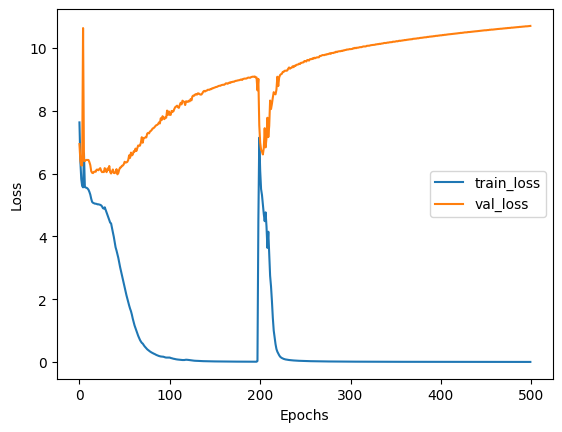

In [74]:
# Plot training history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

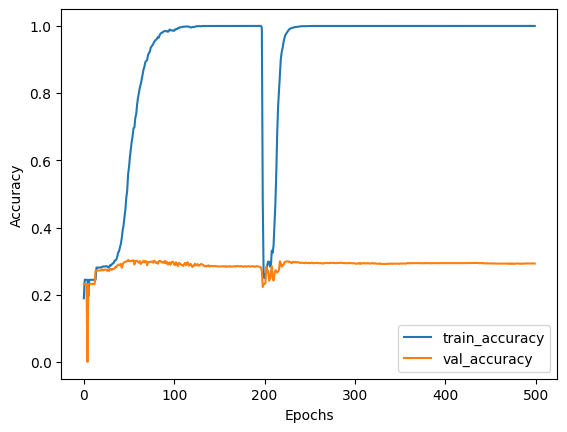

In [75]:
# Plot training history
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Loading the Model

In [76]:
from tensorflow.keras.models import load_model
model = load_model('/kaggle/working/custom_t5_model.keras')


def summarize_news(news_article):
    news_sequence = tokenizer.texts_to_sequences([news_article])
    news_padded = pad_sequences(news_sequence, maxlen=max_news_len, padding='post')
    summary_sequence = model.predict([news_padded, decoder_input_data[:1]])
    summary = tokenizer.sequences_to_texts(summary_sequence.argmax(axis=-1))
    return summary[0]

# Demo
news_article = df['article'].iloc[0]
print("Original Article:", news_article)
print("Generated Summary:", summarize_news(news_article))

Original Article: Supreme Court dismissed the writ petition filed by Himal Iron and Steel Pvt. With the cancellation of the writ, Himal Iron and Steel Pvt Ltd now has to pay the dedicated and trunk line arrears set by the Nepal Electricity Authority.

The joint bench of Supreme Court Chief Justice Prakashman Singh Raut and Mahesh Sharma Paudel on Tuesday ordered the dismissal of Himal Steel's writ. 
 According to the information released by the authority last October, Himal Steel had to pay the bill of Rs. 
 Himal Iron and Steel, operating in Parwanipur under the Parsa Industrial Corridor, had already started paying the arrears of the discounted bill due to consumption of electricity from dedicated and trunk lines. After the authority cut the power line for non-payment of dues in December 2080, the authority connected the line after paying Rs. 27 lakh 10 thousand for the first installment. 
 Himal Steel went to the Supreme Court against the authority in 2075. 
1/1 ━━━━━━━━━━━━━━━━━━━━ 